# Analysis of Airplane Crashes and Safety Trends since 1908: 
## Has the Safety of Air Travel Improved over the Years?

This page explores historical data on airplane crashes since 1908, aiming to determine trends and insights into the evolution of air travel, specifically focusing on whether air travel has improved in safety over the years.. The analysis covers data collection, cleaning, exploratory and in-depth analysis, and visualisations to understand trends and draw insights. 

According to PBS (https://www.pbs.org/wgbh/nova/planecrash/risky.html), the annual risk of being killed in a plane crash for the average Americain is about 1 in 11 million. However, I am not American, so I've chosen this data-driven topic to explore.

In [340]:
from IPython.display import Image, display, Markdown

image_url = 'https://images.ctfassets.net/bht415zek091/12581-image-1/a7ce113ab29b84f231fb05debfca56e6/12581-image-1.jpeg'
display(Image(url=image_url))

copyright_text = """
**Image Source:** [Link to Image](https://images.ctfassets.net/bht415zek091/12581-image-1/a7ce113ab29b84f231fb05debfca56e6/12581-image-1.jpeg)  
"""
display(Markdown(copyright_text))



**Image Source:** [Link to Image](https://images.ctfassets.net/bht415zek091/12581-image-1/a7ce113ab29b84f231fb05debfca56e6/12581-image-1.jpeg)  


In [377]:
# import required libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr
import numpy as np
import plotly.express as px
from IPython.display import Markdown, display
import matplotlib.dates as mdates
import calendar
import plotly.graph_objs as go
from sklearn.linear_model import LinearRegression
import plotly.offline as py
py.init_notebook_mode(connected=True)
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [342]:
# import cleaned csv file
crashes = pd.read_csv('cleaned_crashes.csv')

In [343]:
# convert 'Date' to datetime format
crashes['Date'] = pd.to_datetime(crashes['Date'])

# add a new column for just the year
crashes['Year'] = crashes['Date'].dt.year

In [344]:
# set sns style
sns.set_style('whitegrid')

## Setting the Scene with a Historical Overview

Let's begin by first understanding the scope we are considering here, just exactly how many airplane crashes and fatalities due to crashes have there been since 1908?

In [345]:
total_crashes = len(crashes)
total_fatalities = int(crashes['Fatalities'].sum())
nan_countries = (crashes['Country'] == 'Unknown').sum()

text = """
Firstly, a little bit about the data itself. This data comes from <a href="https://www.kaggle.com/datasets/saurograndi/airplane-crashes-since-1908">Kaggle.com</a> and covers airplane crashes since 1908. 
This data set has information on {} plane crashes and {} resulting fatalities. During my pre-processing, a new column was added to denote the country 
every airline was from, however for many particularly niche and now defunct small aircraft companies it was not possible 
to locate the country of origin. There are {} missing values, which is something worth improving on if I had more time to provide 
a fully comprehensive analysis. For this investigation nevertheless, these missing values do not have a detrimental 
impact on the conclusions drawn.
""".format(total_crashes, total_fatalities, nan_countries)

display(Markdown('<div style = "font-size: 15px;">{}</div>'.format(text)))

<div style = "font-size: 15px;">
Firstly, a little bit about the data itself. This data comes from <a href="https://www.kaggle.com/datasets/saurograndi/airplane-crashes-since-1908">Kaggle.com</a> and covers airplane crashes since 1908. 
This data set has information on 5268 plane crashes and 105479 resulting fatalities. During my pre-processing, a new column was added to denote the country 
every airline was from, however for many particularly niche and now defunct small aircraft companies it was not possible 
to locate the country of origin. There are 50 missing values, which is something worth improving on if I had more time to provide 
a fully comprehensive analysis. For this investigation nevertheless, these missing values do not have a detrimental 
impact on the conclusions drawn.
</div>

Now, confident with the omission of missing values do not skew our results, the next steps focus on basic visualisations of our data on plane crashes. Below is a plot depicting the number of airplane crashes noted per year. 

#### Number of Airplane Crashes per Year

In [365]:
# calculate total number of crashes per year
crashes_per_year = crashes.groupby('Year').size().reset_index()
crashes_per_year.columns = ['Year', 'Number of Crashes']

# plot number of airplane crashes per year
fig_crashes = px.line(crashes_per_year, 
              x = 'Year', 
              y = 'Number of Crashes', 
              title = 'Number of Airplane Crashes per Year',
              markers = True,
              labels = {'Number of Crashes': 'Number of Crashes', 'Year': 'Year'})

# customise
fig_crashes.update_traces(line = dict(width = 3, color = 'dodgerblue'), 
                  marker = dict(size = 7, color = 'lightskyblue', line = dict(width = 1, color = 'slategrey')))

fig_crashes.update_layout(
    template = 'plotly_white',
    title={'text': 'Number of Airplane Crashes Per Year', 'y': 0.9, 'x': 0.5, 'xanchor': 'center', 'yanchor': 'top'},
    title_font = dict(size = 24, color = 'slategrey'),
    autosize = False, width = 900, height = 600,
    xaxis = dict(title_text = 'Year', title_font = dict(size = 18, color = 'slategrey'), tickfont = dict(family = 'Rockwell', color = 'steelblue', size = 12)),
    yaxis=dict(title_text="Number of Crashes", title_font = dict(size = 18, color = 'slategrey'), tickfont = dict(family='Rockwell', color = 'steelblue', size = 12))
)

fig_crashes.show()

Without any contextual knowledge, if one just observed this plot it would be valid to suggest that the safety of aircrafts has decreased over time as crashes have become much more common since 1908. There are a few patterns which can be observed here. The first plane was flown in 1903 (https://airandspace.si.edu/collection-objects/1903-wright-flyer/nasm_A19610048000), and especially since the end of World War II, commercial airliners have soared in popularity (https://airandspace.si.edu/explore/stories/commercial-aviation-mid-century#:~:text=After%20World%20War%20II%2C%20passenger,began%20to%20revolutionize%20civil%20aviation). With increasing number of flights, the number of airplane crashes can also reasonably be expected to increase - this does not necessarily mean that flights have become less safe. The peak seen around 1945 is likely a result of WWII, but we can split the number of crashes by operator type (either military or commerical) to further observe these trends.

We can examine the split between commerical and military operators by plotting this time-series graph categorised by operator type. Military flights often operate in unique environments, under different regulations compared to commerical flights and might exhibit distinct patterns. Below shows this plot.

#### Number of Airplane Crashes per Year by Operator Type

In [366]:
# categorise the crashes
crashes['Type'] = crashes['Operator'].apply(lambda x: 'Military' if 'Military' in str(x) else 'Commercial')

# group by 'Year' and 'Type' and count number of crashes
crashes_per_year_type = crashes.groupby(['Year', 'Type']).size().reset_index(name = 'Number of Crashes')

# plot number of airplane craashes per year separating military and commercial flights
fig_operator = px.line(crashes_per_year_type, 
              x = 'Year', 
              y = 'Number of Crashes', 
              color = 'Type',  
              title = 'Number of Airplane Crashes per Year by Operator Type',
              markers = True,  
              labels = {'Number of Crashes': 'Number of Crashes', 'Year': 'Year', 'Type': 'Operator Type'})

# customise
fig_operator.update_traces(line = dict(width = 3), 
                  marker = dict(size = 7, line = dict(width = 1)))

fig_operator.update_layout(
    template = 'plotly_white',
    title = {'text': "Number of Airplane Crashes per Year by Operator Type", 'y': 0.9, 'x': 0.5, 'xanchor': 'center', 'yanchor': 'top'},
    title_font = dict(size = 24, color = 'slategrey'),
    xaxis_title_font = dict(size = 18, color = 'slategrey'),
    yaxis_title_font = dict(size = 18, color = 'slategrey'),
    xaxis = dict(tickfont = dict(family = 'Rockwell', color = 'steelblue', size = 12)),
    yaxis = dict(tickfont = dict(family = 'Rockwell', color = 'steelblue', size = 12)),
    legend_title_font = dict(size = 18, color = 'slategrey'),
    legend = dict(font = dict(size = 12, color = 'slategrey')),
    autosize = False, width = 900, height = 600
)

colours = {'Military': 'cadetblue', 'Commercial': 'mediumslateblue'}  
fig_operator.for_each_trace(lambda x: x.update(line = dict(color = colours[x.name]), 
                                      marker = dict(color = colours[x.name])))

fig_operator.show()

The above visualisation distinguishes the number of airplane crashes by the type of operator, either military or commercial flights. Both types show significant variability over the years, with different periods of peaks and troughs. Military crashes were very few in numbers in the early years, with a slight peak during World War I (1914-1918), staying low until World War II (1939-1945). 1945 is the only year on record where the number of military crashes exceeded commerical crashes. Commerical crashes have seen a large increase since 1908, but appear to be declining as we move into the 21st century, which could possibly reflect increased safety measures being successfully implemented. 

Building upon this examination of the frequency of airplane crashes by operator types, it is essential to understand the pattern between the quantity of crashes compared to the fatalities caused by these crashes. This will help aid understanding in the efficacy of safety measures and operational practices, and whether this has improved over time. 

#### Number of Fatalities per Year by Operator Type

In [367]:
# group data by 'Year' and 'Type' and count number of fatalities
fatalities_per_year_type = crashes.groupby(['Year', 'Type'])['Fatalities'].sum().reset_index(name = 'Number of Fatalities')

# plot numer of fatalities per year by operator type
fig_fatalities = px.line(fatalities_per_year_type, 
                         x = 'Year', 
                         y = 'Number of Fatalities', 
                         color = 'Type', 
                         title = 'Number of Airplane Fatalities per Year by Operator Type',
                         markers = True,
                         labels = {'Number of Fatalities': 'Number of Fatalities', 'Year': 'Year', 'Type': 'Operator Type'})

# customise
fig_fatalities.update_traces(line = dict(width = 3), 
                             marker = dict(size = 7, line = dict(width = 1)))

fig_fatalities.update_layout(
    template = "plotly_white",
    title = {'text': "Number of Airplane Fatalities per Year by Operator Type", 'y': 0.9, 'x': 0.5, 'xanchor': 'center', 'yanchor': 'top'},
    title_font = dict(size = 24, color = 'slategrey'),
    xaxis_title_font = dict(size = 18, color = 'slategrey'),
    yaxis_title_font = dict(size = 18, color = 'slategrey'),
    xaxis = dict(tickfont = dict(family = 'Rockwell', color = 'steelblue', size = 12)),
    yaxis = dict(tickfont = dict(family = 'Rockwell', color = 'steelblue', size = 12)),
    legend_title_font = dict(size = 18, color = 'slategrey'),
    legend = dict(font = dict(size = 12, color = 'slategrey')),
    autosize = False, width = 900, height =  600
)

colours = {'Military': 'cadetblue', 'Commercial': 'mediumslateblue'}  
fig_fatalities.for_each_trace(lambda x: x.update(line = dict(color = colours[x.name]), 
                                                 marker = dict(color = colours[x.name])))

fig_fatalities.show()

Here, we see a similar pattern to the number of airplane crashes plot - incidcating, as one might expect, that the higher the airplane crashes the higher the airplane crash fatalities. The spikes exhibited around the 1980s suggest one or a few extremely deadly airplane crashes may have occured, and the subsequent drop in fatalities may be a result of improvements in aviation safety. Following on from this, it is worthwhile to explore the deadliest years in aviation, aiming to understand the specific circumstances that caused these years to be so deadly and whether they caused an impact on future safety measures. 

# Investigating the Turbulent Years in Aviation History

Here, we examine the years with the highest fatalities. Below is a table showcasing the worst three years for fatalities.

In [349]:
# group by year, sum fatalities and count crashes
year = crashes.groupby('Year').agg({'Fatalities': 'sum', 'Date': 'count'}).reset_index()

# sort data by the number of crashes in descending order
crashes_rank = year.sort_values(by = 'Date', ascending = False)

# find top 3 deadliest years by fatalities
fatalities_rank = year.sort_values(by = 'Fatalities', ascending = False).head(3)

# calculate the crashes rank
year['Crashes_Rank'] = year['Date'].rank(ascending = False).astype(int)

# merge the top 3 deadliest years with respective crash ranks
top_3_years = pd.merge(fatalities_rank, crashes_rank, on = 'Year', suffixes = ('_Fatalities', '_Crashes'))

# merge the rank based on all years
top_3_years = pd.merge(top_3_years, year[['Year', 'Crashes_Rank']], on = 'Year')

# sort by fatalities
top_3_years = top_3_years.sort_values(by = 'Fatalities_Fatalities', ascending = False)

# rename column titles
top_3_years = top_3_years.rename(columns = {'Fatalities_Fatalities': 'Fatalities', 'Date_Crashes': 'Number of Crashes', 'Crashes_Rank': 'Crashes Rank'})

# print("Top 3 Worst Years by Fatalities and Their Respective Crash Rank:")
# print(top_3_years[['Year', 'Fatalities', 'Number of Crashes', 'Crashes Rank']].to_string(index=False))

# print in markdown below

In [350]:
# find top 3 worst years by number of crashes
crashes_top_3 = crashes_rank.head(3)

# calculate the fatalities rank
year['Fatalities_Rank'] = year['Fatalities'].rank(ascending=False).astype(int)

# merge the top 3 worst years by crashes with respective fatalities ranks
top_3_crashes = pd.merge(crashes_top_3, year[['Year', 'Fatalities_Rank']], on = 'Year')

# sort by crashes
top_3_crashes = top_3_crashes.sort_values(by = 'Date', ascending = False)

# rename column titles
top_3_crashes = top_3_crashes.rename(columns = {'Date': 'Number of Crashes', 'Fatalities_Rank': 'Fatalities Rank'})

# print("Top 3 Worst Years by Crashes and Their Respective Fatalities Rank:")
# print(top_3_crashes[['Year', 'Number of Crashes', 'Fatalities', 'Fatalities Rank']].to_string(index = False))

# print in markdown below

### Top 3 Deadliest Years by Fatalities and Corresponding Crash Rankings

| Rank | Year | Fatalities | Crashes | Crashes Rank |
|---|------|------------|---------|--------------|
| 1 | 1972 | 2937    | 104     | 1            |
| 2 | 1985 | 2670     | 74      | 25           |
| 3 | 1973 | 2485     | 89      | 5            |

### Top 3 Years with the Highest Number of Crashes and Corresponding Fatalities Rankings

| Rank | Year | Crashes | Fatalities | Fatalities Rank |
|---|------|---------|------------|-----------------|
| 1 | 1972 | 104     | 2937    | 1               |
| 2 | 1968 | 96      | 2156     | 7               |
| 3 | 1989 | 95      | 2293     | 6               |


Above is two tables first presenting a comparative analysis of the top three deadliest years in aviation history, ranked by the total number of fatalities, and second presenting the top three years in aviation history with the highest number of crashes. Strikingly, the year 1972 is the worst year in aviation, with the highest number of crashes, at 104, with nearly 3000 fatalities. The second deadliest year was 1985, but when ranked by number of crashes, it is 25th, indicating this year had a few large-scale disasters with high fatalities, rather than a number of smaller incidents. Overall, this table reveals the complex variability behind avidation incidents, and shows that a higher number of crashes doesn't always correlate with higher fatalities, and vice versa. The year 1972 is anomalously catastrophic, so it is worth investigating what specifically happened. 

## Exploring the Unusually Disastrous 1972

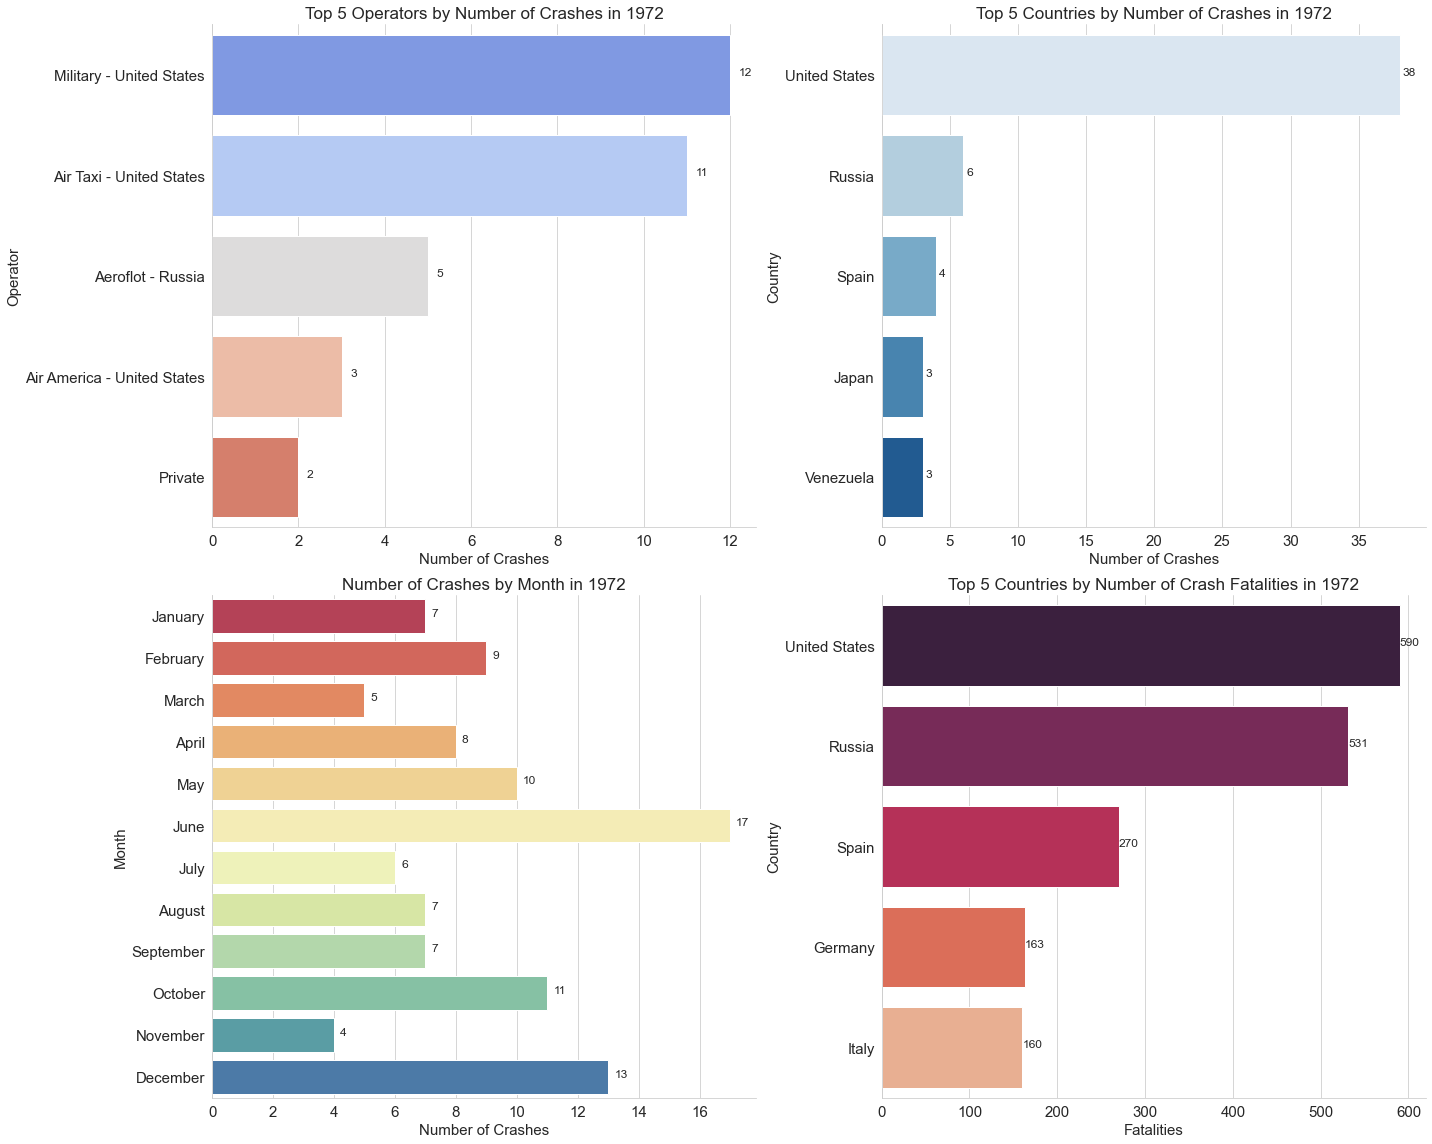

In [351]:
crashes_1972 = crashes[crashes['Year'] == 1972].copy()

# set up 2x2 plot
fig, axs = plt.subplots(2, 2, figsize = (20, 16))

# 1: top operators by number of crashes

# find top 5 operators with highest number of crashes in 1972
operators_1972 = crashes_1972['Operator'].value_counts().head(5)
# bar plot of these operators
sns.barplot(y = operators_1972.index, x = operators_1972.values, ax = axs[0, 0], palette = 'coolwarm')
# set titles
axs[0, 0].set_title('Top 5 Operators by Number of Crashes in 1972', fontsize = 17)
axs[0, 0].set_xlabel('Number of Crashes', fontsize = 15)
axs[0, 0].set_ylabel('Operator', fontsize = 15)
axs[0, 0].tick_params(labelsize = 15)
# add value labels 
for p in axs[0, 0].patches:
    axs[0, 0].text(p.get_width() + 0.2, p.get_y() + p.get_height() / 2, f'{int(p.get_width())}', fontsize = 12)


# 2: top countries by number of crashes

# find top 5 countries with highest number of crashes in 1972
countries_1972 = crashes_1972['Country'].value_counts().head(5)
# bar plot of these countries
sns.barplot(y = countries_1972.index, x = countries_1972.values, ax = axs[0, 1], palette = 'Blues')
# set titles
axs[0, 1].set_title('Top 5 Countries by Number of Crashes in 1972', fontsize = 17)
axs[0, 1].set_xlabel('Number of Crashes', fontsize = 15)
axs[0, 1].set_ylabel('Country', fontsize = 15)
axs[0, 1].tick_params(labelsize = 15)
# add value labels
for p in axs[0, 1].patches:
    axs[0, 1].text(p.get_width() + 0.2, p.get_y() + p.get_height() / 2, f'{int(p.get_width())}', fontsize = 12)


# 3: crashes by month

# subset 1972 crash data by month
crashes_month_1972 = crashes_1972['Date'].dt.month.value_counts().sort_index()
# define month name using calendar package
month = [calendar.month_name[i] for i in range(1, 13)]
# bar plot of crashes in 1972 by month
sns.barplot(x = crashes_month_1972.values, y = month, ax = axs[1, 0], palette = 'Spectral')
# set titles
axs[1, 0].set_title('Number of Crashes by Month in 1972', fontsize = 17)
axs[1, 0].set_xlabel('Number of Crashes', fontsize = 15)
axs[1, 0].set_ylabel('Month', fontsize = 15)
axs[1, 0].tick_params(labelsize = 15)
# add value labels
for p in axs[1, 0].patches:
    axs[1, 0].text(p.get_width() + 0.2, p.get_y() + p.get_height() / 2, f'{int(p.get_width())}', fontsize = 12)


# 4: top fatalities by country

# find top 5 countries by number of fatalities in 1972
fatalities_1972 = crashes_1972.groupby('Country')['Fatalities'].sum().sort_values(ascending = False).head(5)
# bar plot of fatalities 
sns.barplot(y = fatalities_1972.index, x = fatalities_1972.values, ax = axs[1, 1], palette = 'rocket')
# add titles
axs[1, 1].set_title('Top 5 Countries by Number of Crash Fatalities in 1972', fontsize = 17)
axs[1, 1].set_xlabel('Fatalities', fontsize = 15)
axs[1, 1].set_ylabel('Country', fontsize = 15)
axs[1, 1].tick_params(labelsize = 15)
# add value labels
for p in axs[1, 1].patches:
    axs[1, 1].text(p.get_width() + 0.2, p.get_y() + p.get_height() / 2, f'{int(p.get_width())}', fontsize = 12)

sns.despine()
plt.tight_layout()
plt.show()


The figures above provide a few details regarding what caused the year 1972 to be particularly disasterous. 

**Operator Analysis**

From the top left chart, we can see the United States military experienced the most crashes, followed by Air Taxi services, also a US company, indicating a significant number of aviation incidents in 1972 were related to aviation within the USA. 

**Country Analysis**

The second chart further supports these findings regarding the USA, finding they far exceed other countries in the number of crashes, with 36 plane crashes that year. This is followed by Russia (at the time the Soviet Union), with six crashes, where five were caused by the company Aeroflot, the largest Russian airline.

**Month Distribution**

From this chart, we see there were notable spikes in the number of crashes in June and December. The June spike could be as a result of increased travel during the Summer months, and December could be due to a combination of increased travel due to the holiday season and adverse weather conditions. 

**Fatalities by Country**

The final chart reveals again the USA had a particularly devastating aviation year, with the highest number of fatalities. However, interestingly they are closely followed by Russia, with 531 fatalities, indicating the USA had a high number of crashes, but had lower casualty rates. This difference shows it's important to consider the number of crashes and the accompanying fatalities. On this note, it is useful to look at the chances of survival in this year compared to other years.

## Chances of Survival

In [352]:
# scatterplot of fatalities vs aboard: 1972
fig_1972 = px.scatter(crashes_1972, x = 'Aboard', y = 'Fatalities', title = 'Fatalities vs. Number Aboard in 1972',
                      labels={'Aboard': 'Number Aboard', 'Fatalities': 'Number of Fatalities'},
                      trendline = 'ols', trendline_color_override = 'slategrey')
fig_1972.update_traces(
    marker = dict(color = 'mediumslateblue', size = 10, opacity = 0.7,
                line = dict(width = 0.7, color = 'black')))
fig_1972.update_layout(width = 900, height = 500)


# create subset for every year excluding 1972
crashes_n_1972 = crashes[crashes['Year'] != 1972].copy()
# scatterplot of fatalities vs aboard: all other years
fig_all_years = px.scatter(crashes_n_1972, x = 'Aboard', y = 'Fatalities', title = 'Fatalities vs. Number Aboard in all other Years',
                           labels={'Aboard': 'Number Aboard', 'Fatalities': 'Number of Fatalities'},
                           trendline = 'ols', trendline_color_override = 'slategrey')
fig_all_years.update_traces(
    marker = dict(color = 'mediumslateblue', size = 10, opacity = 0.7,
                  line = dict(width = 0.7, color = 'black')))
fig_all_years.update_layout(width = 900, height = 500)

fig_1972.show()
fig_all_years.show()


The two plots above depict a comparison of the relationship between the number of people aboard a plane and the number of fatalities in crashes in 1972 and all other years respectively. In both plots there is a positive correlation between number of people aboard and number of fatalities, following intuitive sense. There is a much more consistent ratio of fatalities to people aboard for 1972 than when compared to the other years. There is much more variability in other years, and especially there is a lot more crashes where there were high numbers of people aboard but with minimal fatalities. The steeper regression slope in 1972 indicates a higher chance of fatalities per person aboard in crashes that year, possibly reflecting less effective safety practices or other situational factors at the time. 

# A Note on Survival Rates

We can use a similar concept to the above plots to determine survival rates. Assessing survival rates in aviation crashes can be insightful into the effectiveness of safety measures introduced over time. We already know air crashes became much more frequent and deadly as the popularity of air travel heightened. By just looking at survival rates, we can examine if air travel has become safer despite more crashes. As I am based in the UK, I am specifically interested in the patterns seen in UK plane crashes, and comparing this to the rest of the world.

In [353]:
# ensure 'Year' is in datatime format
crashes['Year'] = pd.to_datetime(crashes['Year'], format='%Y')

# filter for just UK crashes
UK = crashes[(crashes['Country'] == 'United Kingdom')].copy()

# filter for all other countries
n_UK = crashes[(crashes['Country'] != 'United Kingdom')].copy()

# calculate survival rate per year for UK crashes
UK['Survivors'] = UK['Aboard'] - UK['Fatalities']
UK_survival_rate = UK.groupby(UK['Year'].dt.year).agg({'Survivors': 'sum', 'Aboard': 'sum'})
UK_survival_rate['Survival Rate (%)'] = (UK_survival_rate['Survivors'] / UK_survival_rate['Aboard']) * 100

# calculate survival rate per year for other countries crashes
n_UK['Survivors'] = n_UK['Aboard'] - n_UK['Fatalities']
n_UK_survival_rate = n_UK.groupby(n_UK['Year'].dt.year).agg({'Survivors': 'sum', 'Aboard': 'sum'})
n_UK_survival_rate['Survival Rate (%)'] = (n_UK_survival_rate['Survivors'] / n_UK_survival_rate['Aboard']) * 100

# merge both data frames on Year
merged_survival_rate = pd.merge(UK_survival_rate, n_UK_survival_rate, on = 'Year', suffixes=('_UK', '_Others'))

# filter out years with no survivors for UK crashes
merged_survival_rate_UK = merged_survival_rate[merged_survival_rate['Survivors_UK'] > 0]

# predict and fit linear regression for UK crashes
X_UK = merged_survival_rate_UK.index.values.reshape(-1, 1)
y_UK = merged_survival_rate_UK['Survival Rate (%)_UK'].values.reshape(-1, 1)
model_UK = LinearRegression().fit(X_UK, y_UK)
predicted_y_UK = model_UK.predict(X_UK)

# filter out years with no survivors for other countries crashes
merged_survival_rate_Others = merged_survival_rate[merged_survival_rate['Survivors_Others'] > 0]

# predict and fit linear regression for other countries crashes
X_Others = merged_survival_rate_Others.index.values.reshape(-1, 1)
y_Others = merged_survival_rate_Others['Survival Rate (%)_Others'].values.reshape(-1, 1)
model_Others = LinearRegression().fit(X_Others, y_Others)
predicted_y_Others = model_Others.predict(X_Others)

# create the traces for UK crashes
trace1_UK = go.Scatter(x=merged_survival_rate_UK.index, y=merged_survival_rate_UK['Survival Rate (%)_UK'],
                       mode='lines+markers', name='Survival Rate (UK)', line=dict(color='red'))
trace2_UK = go.Scatter(x=merged_survival_rate_UK.index, y=predicted_y_UK.flatten(),
                       mode='lines', line=dict(dash='dashdot', color='salmon'), name='Linear Trendline (UK)')

# create the traces for other countries crashes
trace1_Others = go.Scatter(x=merged_survival_rate_Others.index, y=merged_survival_rate_Others['Survival Rate (%)_Others'],
                           mode='lines+markers', name='Survival Rate (Rest of World)', line=dict(color='olivedrab'))
trace2_Others = go.Scatter(x=merged_survival_rate_Others.index, y=predicted_y_Others.flatten(),
                           mode='lines', line=dict(dash='dashdot', color='yellowgreen'), name='Linear Trendline (Rest of World)')

# create the layout
layout = go.Layout(title="Comparing the UK's Survival Rate per Year with the Rest of the World",
                   xaxis=dict(title='Year'),
                   yaxis=dict(title='Survival Rate (%)', range=[-5, 105]),
                   hovermode='closest',
                   width=900,
                   height=500)

# create figure
fig_survival_rate = go.Figure(data=[trace1_UK, trace2_UK, trace1_Others, trace2_Others], layout=layout)
fig_survival_rate.update_layout(template="plotly_white")

fig_survival_rate.show()

This plot shows the survival rates from the airplane crashes per year, specifically comparing UK crashes with other countries. The trendline for both the UK and the rest of the world show an upward trajectory, supporting the notion air trvael has become safer over the years. This is significant as we know air travel has exponentially increased in frequency as well as subsequently the frequency of air crashes. Examining the UK's survival rate, we see in the early 20th century, the survival was actually lower than the global average, but this is likely due to few pieces of data as air travel was only just starting to be used. There is notably much more variation in the survival rate for UK crashes, which is again likely as a result due to few pieces of data as some years there are either none or few plane crashes.  Nowadays, the survival rate for UK airplanes is just under 20% higher than the global average. 

# A Comparative Analysis of Airplane Crashes by Country

Now, to wrap up, we can explore airplane crashes by country visually.

In [369]:
# count fatalities per country
crashes_count = crashes.groupby('ISO_Code').size().reset_index(name = 'Crashes')

# create choropleth map
fig_country = px.choropleth(crashes_count, 
                    locations = 'ISO_Code',
                    color = 'Crashes',
                    hover_name = 'ISO_Code',
                    color_continuous_scale = px.colors.sequential.Viridis_r,  
                    title = 'Total Plane Crashes per Country')

# amend layout
fig_country.update_layout(
    geo = dict(
        showframe = True, 
        showcoastlines = True, 
        projection_type = 'natural earth'),
    title = dict(x = 0.5, xanchor = 'center'),
    coloraxis_colorbar = dict(title = 'Total Crashes', tickformat = ',d'),
    width = 1200, height = 600
)

fig_country.show()

The above map demonstrates a global distribution of plane crahses, but clearly shows that some countries have much higher frequencies of crashes. Notably, the USA is by far the country with the highest number of crashes, shown in dark purple. However, due to the nature of aviation, we cannot make the conclusion that there is a higher risk flying an American company compared with, for example, an African airline who have experienced much less crashes. Additional context would be required for those types of conclusions, as from our previous inidications in this report it seems much more likely the countries with more air traffic are likely to have more air crashes purely due to the higher number of flights, not an increased risk. It therefore might also be useful to examine the number of fatalities in each country, to visualise how well countries have managed safety measures and emergency responses to mitigate loss of life. 

In [372]:
# count fatalities per country
fatalities_count = crashes.groupby('ISO_Code')['Fatalities'].sum().reset_index()

# create choropleth map
fig_fatalities_country = px.choropleth(fatalities_count, 
                    locations = 'ISO_Code',
                    color = 'Fatalities',
                    hover_name = 'ISO_Code',
                    color_continuous_scale = px.colors.sequential.Inferno_r,  
                    title = 'Total Fatalities per Country')

# amend layout
fig_fatalities_country.update_layout(
    geo = dict(
        showframe = True, 
        showcoastlines = True, 
        projection_type = 'natural earth'),
    title = dict(x = 0.5, xanchor = 'center'),
    coloraxis_colorbar = dict(title = 'Total Fatalities', tickformat = ',d'),
    width = 1200, height = 600
)

fig_fatalities_country.show()


The above map mostly results in the same conclusion as when examining the number of plane crashes by country, with one notable exception. Russia (USSR) have experienced similar numbers of plane crashes as the UK and France, but they have a much higher fatality count. This discrepancy in fatalities despite a similar crash numbers could be caused by a number of factors. It could reflect severity of the crashes, due to challenging weather conditions or terrain, increasing the likelihood of fatalities in a crash. This could also be caused by specific differences in the type of planes used in Russia, i.e. larger planes may be more common, likely resulting in higher fatality numbers per crash. However, it could also be as a result of the poor safety regulations or oversights. To really explore the discrepancy between crashes and fatalities, we can consider survival rates for each country.

In [373]:
# calculate survivors
crashes['Survivors'] = crashes['Aboard'] - crashes['Fatalities']

# group by ISO_Code and calculate total survivors and total aboard for each country
survival_stats = crashes.groupby('ISO_Code').agg({'Survivors': 'sum', 'Aboard': 'sum'}).reset_index()

# calculate survival rate as a percentage
survival_stats['Survival Rate (%)'] = (survival_stats['Survivors'] / survival_stats['Aboard']) * 100

# plot survival rate on the map
fig_survival = px.choropleth(survival_stats, 
                    locations = "ISO_Code",
                    color = "Survival Rate (%)",
                    hover_name = "ISO_Code",
                    color_continuous_scale = px.colors.sequential.Hot,  
                    title = 'Survival Rate per Country (%)')

fig_survival.update_layout(
    geo = dict(
        showframe = True, 
        showcoastlines = True, 
        projection_type = 'natural earth'),
    title = dict(x = 0.5, xanchor = 'center'),
    coloraxis_colorbar=dict(title = 'Survival Rate (%)', tickformat = '.2f'),
    width = 1200, height = 600
)

fig_survival.show()


The above map depicts survival rates from plane crashes across different countries, which can be used to determine constrasts and highlight successful measures implemented by specific countries in managing aviation crashes. A higher survival rate could imply there are robust safety measures, effective emergency response, and prompt medical support in these countries' crashes. However, it is important to note that a low survival rate does not necessarily imply this country has poor aviation safety protocols, as they may not have experienced many aviation disasters - the lack of data may cause exaggeratedly low survival rates. Therefore, it is important to note that countries who have high numbers of flights but a relatively good survival rate are particularly notable as there is a higher exposure to risk but maintains a solid response to disasters when they happen. An example of this type of country would be the USA.  

# Summary

In this report, we have explored historical data on airplane crashes to determine whethwer the safety of air travel has improved over the years. The beginning visualisations suggests a fluctuating but a generally downward trend as we enter the 21st century in the frequency of crashes. Aviation accidents is a complex issue to break down into a short report as there are so many different factors affecting different circumstances of a plane crash, such as time period, location, operator, just to name a few. However, it is clear aviation has become significantly safer over time - air travel has boomed in the past century and despite this the number of crashes per year exhibits a downward trend. This improvement is likely due to stricter safety regulations, improved pilot training, and advancements in technology. This trend found in the report aligns with the global effort within the aviation industry to make air travel safer. 

# Predictive Modelling

As an extension, we can create a Random Forest model to demonstrate just one way in which this type of data can be utilised to extrapolate to new, unseen scenarios. Specifically, this example uses the 'sklearn' library to predict the number of fatalities in commerical airplane crashs based on the historical data. 

In [375]:
# filter to only consider commerical crashes
commercial_crashes = crashes[crashes['Type'] == 'Commercial'].copy()

# remove rows with missing values
commercial_crashes = commercial_crashes.dropna()

# ensure 'Date' is in datetime
# extract year, month, and day
commercial_crashes['Date'] = pd.to_datetime(commercial_crashes['Date'])
commercial_crashes['Year'] = commercial_crashes['Date'].dt.year
commercial_crashes['Month'] = commercial_crashes['Date'].dt.month
commercial_crashes['Day'] = commercial_crashes['Date'].dt.day

# drop the 'Date' column
commercial_crashes.drop('Date', axis = 1, inplace = True)

# select numeric variables as features 
features = commercial_crashes.select_dtypes(include = ['int64', 'float64', 'uint8']).columns.tolist()

# remove the target variable
features.remove('Fatalities') 

# set feature vector
X = commercial_crashes[features]
# set target vector
y = commercial_crashes['Fatalities']

# split data into training and testing set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 123)

# train RF regressior with new parameters (preventing overfitting of the model)
rf_regressor = RandomForestRegressor(
    n_estimators = 100,       
    max_depth = 10,         
    min_samples_leaf = 10,    
    max_features = 'sqrt',    
    oob_score = True,      
    random_state=123
)
rf_regressor.fit(X_train, y_train)

# calculate out-of-bag samples
oob_score = rf_regressor.oob_score_
print(f'OOB Score: {oob_score}')


OOB Score: 0.8441543931785893


Here, we have created the model, and evaluated the out-of-bag (OOB) score of 0.844. This score suggests the model is highly accurate in its predictions, and demonstrates a strong ability to generalise to unseen data. 

In [378]:
# predict on the test set
y_pred = rf_regressor.predict(X_test)

# calculate evaluation metrics
print(f'Mean Absolute Error (MAE): {mean_absolute_error(y_test, y_pred)}')
print(f'Mean Squared Error (MSE): {mean_squared_error(y_test, y_pred)}')
print(f'Root Mean Squared Error (RMSE): {mean_squared_error(y_test, y_pred) ** 0.5}')
print(f'R-squared (R2): {r2_score(y_test, y_pred)}')


Mean Absolute Error (MAE): 5.366702236404334
Mean Squared Error (MSE): 161.31736036993544
Root Mean Squared Error (RMSE): 12.701077134240837
R-squared (R2): 0.8607565681323086


These performance metrics provide a comprehensive view on our Random Forest's predictive accuracy regarding the number of fatalities in commerical airplane crashes. Notably, we have the root mean squared error of 12.701 fatalities per prediction, as well as the R-squared value of 0.861. This R-squared value indicates that approximately 86.1% of the variance in the number of fatalities is explained by this model, which is a very good score. These metrics confirm the model is accurate and robust at predicting fatalities in commerical crashes.

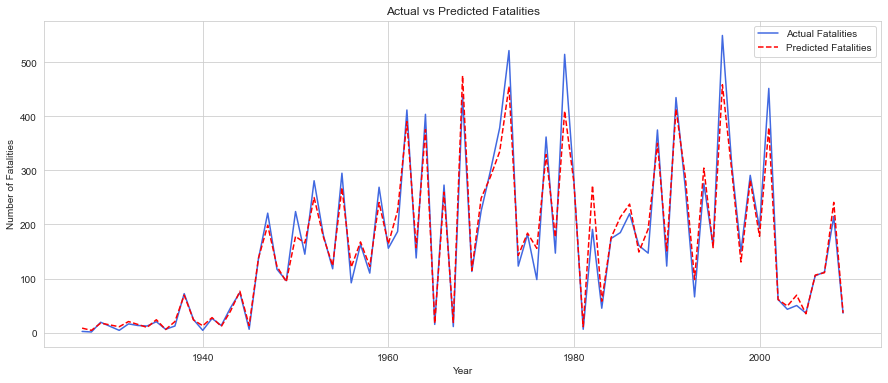

In [387]:
# combine predictions with the actual fatalities and the test set
test_predictions = X_test.copy()
test_predictions['Actual Fatalities'] = y_test
test_predictions['Predicted Fatalities'] = y_pred

# group by year
year_data = test_predictions.groupby('Year').agg({'Actual Fatalities': 'sum', 'Predicted Fatalities': 'sum'}).reset_index()

# plot
plt.figure(figsize = (15, 6))
plt.plot(year_data['Year'], year_data['Actual Fatalities'], label = 'Actual Fatalities', color = 'royalblue')
plt.plot(year_data['Year'], year_data['Predicted Fatalities'], label = 'Predicted Fatalities', color = 'red', linestyle = '--')
plt.xlabel('Year')
plt.ylabel('Number of Fatalities')
plt.title('Actual vs Predicted Fatalities')
plt.legend()
plt.show()


The plot above compares the actual fatalities to fatalities predicted by the Random Forest model over time. The model appears to follow the general trend, following similar patterns, indicating the model has learned the general trend of the data. Where there are peaks and troughs in the data, the model captures these imperfectly, which is preferred as it suggests the model is sensitive to fluctuations but extreme values in the data can be a result of noise or outliers. The model appears to perform better in the earlier years, suggesting the model could potentially be improved by using more advanced time-series modelling which can account for these temporal differences. 

To give an example on how a model like this can be used in practical situations, we can explore how variations in passenger numbers could impact the safety outcomes of flights. This can be done by conducting a simulation scenario using this Random Forest model. Firstly a baseline scenario is established by using the median values in the training set data. Then a new scenario is simulated by increasing the number of passengers, with the aim to observe how this change could influence predicted fatalities.

In [388]:
# define a function to alter features and predict outcomes
def simulate_scenario(baseline, aboard):
    scenario = baseline.copy()
    
    # simulate more people aboard
    scenario['Aboard'] += aboard
    
    # predict the outcome now
    predicted_fatalities = rf_regressor.predict(scenario)

    return predicted_fatalities

# use median values from your training data as the baseline features
baseline = pd.DataFrame([X_train.median()])

# simulate a scenario with 10 more passengers
aboard = 10 

# get predicted outcomes for both cases
baseline_fatalities = simulate_scenario(baseline, 0)
aboard_fatalities = simulate_scenario(baseline, aboard)

print(f"Predicted fatalities (baseline passengers): {baseline_fatalities[0]}")
print(f"Predicted fatalities (passengers + {aboard}): {aboard_fatalities[0]}")


Predicted fatalities (baseline passengers): 11.939230077473155
Predicted fatalities (passengers + 10): 17.812662573836313


I've conducted a scenario simulation, modifying the number of passengers aboard a plane crash to see how this affects the predicted fatalities using the train Random Forest model. My results might alter slightly when this simulation is run again. The baseline prediction (no additional passengers using median values of the training data) is approximately 11.94 fatalities in a 'typical' crash scenario. After increasing the number of passengers aboard by 10, the model predicts the number of fatalities to increase to approximately 17.81. The model predicts that an increase of the number of passengers aboard is associated with an increase in the number of fatalities in the event of a crash. The predicted fatalities increase by about 7.6, a significant increase, implying a strong positive relationship between the number of passengers aboard and number of fatalities. This model may have limitations in how well it can reflect real-world complexities. In reality, there is a complex relationship between passengers aboard and number of fatalities, including factors discussed previously such as the country or type of aircraft. 

In summary, the application of the Random Forest model shows the application of these types of predctive modelling as it has produced a robust and effective method for predicting fatalities in aviation accidents. It demonstrates the usefulness and potential of implementing machine learning techniques in improving aviation safety through data-driven research. 